<a href="https://colab.research.google.com/github/chrs7n/EDA-Report/blob/main/FinalCapstone_UC_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 262k/262k [00:00<00:00, 14.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/saurabhbadole/bank-customer-churn-prediction-dataset/versions/2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
#--
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.tree import _tree
from collections import Counter


sns.set_style("whitegrid")
sns.set_palette("pastel")
pd.set_option("display.max_columns", None)

In [ ]:
# Reading csv file
df = pd.read_csv(path + "/Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# **Exploratory data analysis**

In [ ]:

# Show dataset dimensions
print("Dataset shape:", df.shape)

# Show data types and missing values
print("\nColumn info:")
print(df.info())

# Descriptive statistics for numerical variables
print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (10000, 14)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Descriptive statistics:
         RowNumber    C

In [ ]:
# converting 'HasCrCard','IsActiveMember','Exited' columns to boolean

df['HasCrCard'] = df['HasCrCard'].astype('bool')
df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
df['Exited'] = df['Exited'].astype('bool')


In [ ]:
# Select numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

num_cols = [col for col in num_cols if col not in ['RowNumber','CustomerId']] #,'HasCrCard','IsActiveMember','Exited']]

# Create subplot with 1 row and len(num_cols) columns
fig = make_subplots(rows=1, cols=len(num_cols), subplot_titles=num_cols)

# Add a boxplot for each numeric column
for i, col in enumerate(num_cols):
    fig.add_trace(
        go.Box(y=df[col], name=col, boxpoints='outliers'),
        row=1, col=i+1
    )

# Update layout for spacing
fig.update_layout(
    height=500,
    width=300 * len(num_cols),
    title_text="Boxplots of Numerical Features",
    showlegend=False
)

fig.show()

**Comments:** Outliers are identified in CreditScore, Age and NumOfProducts.
- The majority of customers have an acceptable Credit Scoring, mainly between 600 and 700
- Customer age is commonly between 30 and 45 years old. The younger ones are 20 years old
- The bank doesn't have many products, the maximum is 4 products but the average number of products is 1

In [ ]:
# Columns to plot (in specified order)
#columns = ['id', 'price', 'year', 'odometer']

# Create subplot: 1 row, 4 columns
fig = make_subplots(rows=1, cols=6, subplot_titles=num_cols)

# Add histograms
for i, col in enumerate(num_cols):
    fig.add_trace(
        go.Histogram(x=df[col], name=col),
        row=1, col=i+1
    )

# Update layout
fig.update_layout(
    height=400,
    width=1600,
    title_text="Histograms of Numerical Features",
    showlegend=False
)

fig.show()

**Comments:**
- There is no much older people in the Age distribution, so the bank is focused in the most productive people of the countries.
- Seems to be an error in Balance variable, due to zero balance in an important number of accounts.
- Product penetration is low, a few customers have more than 2 products.

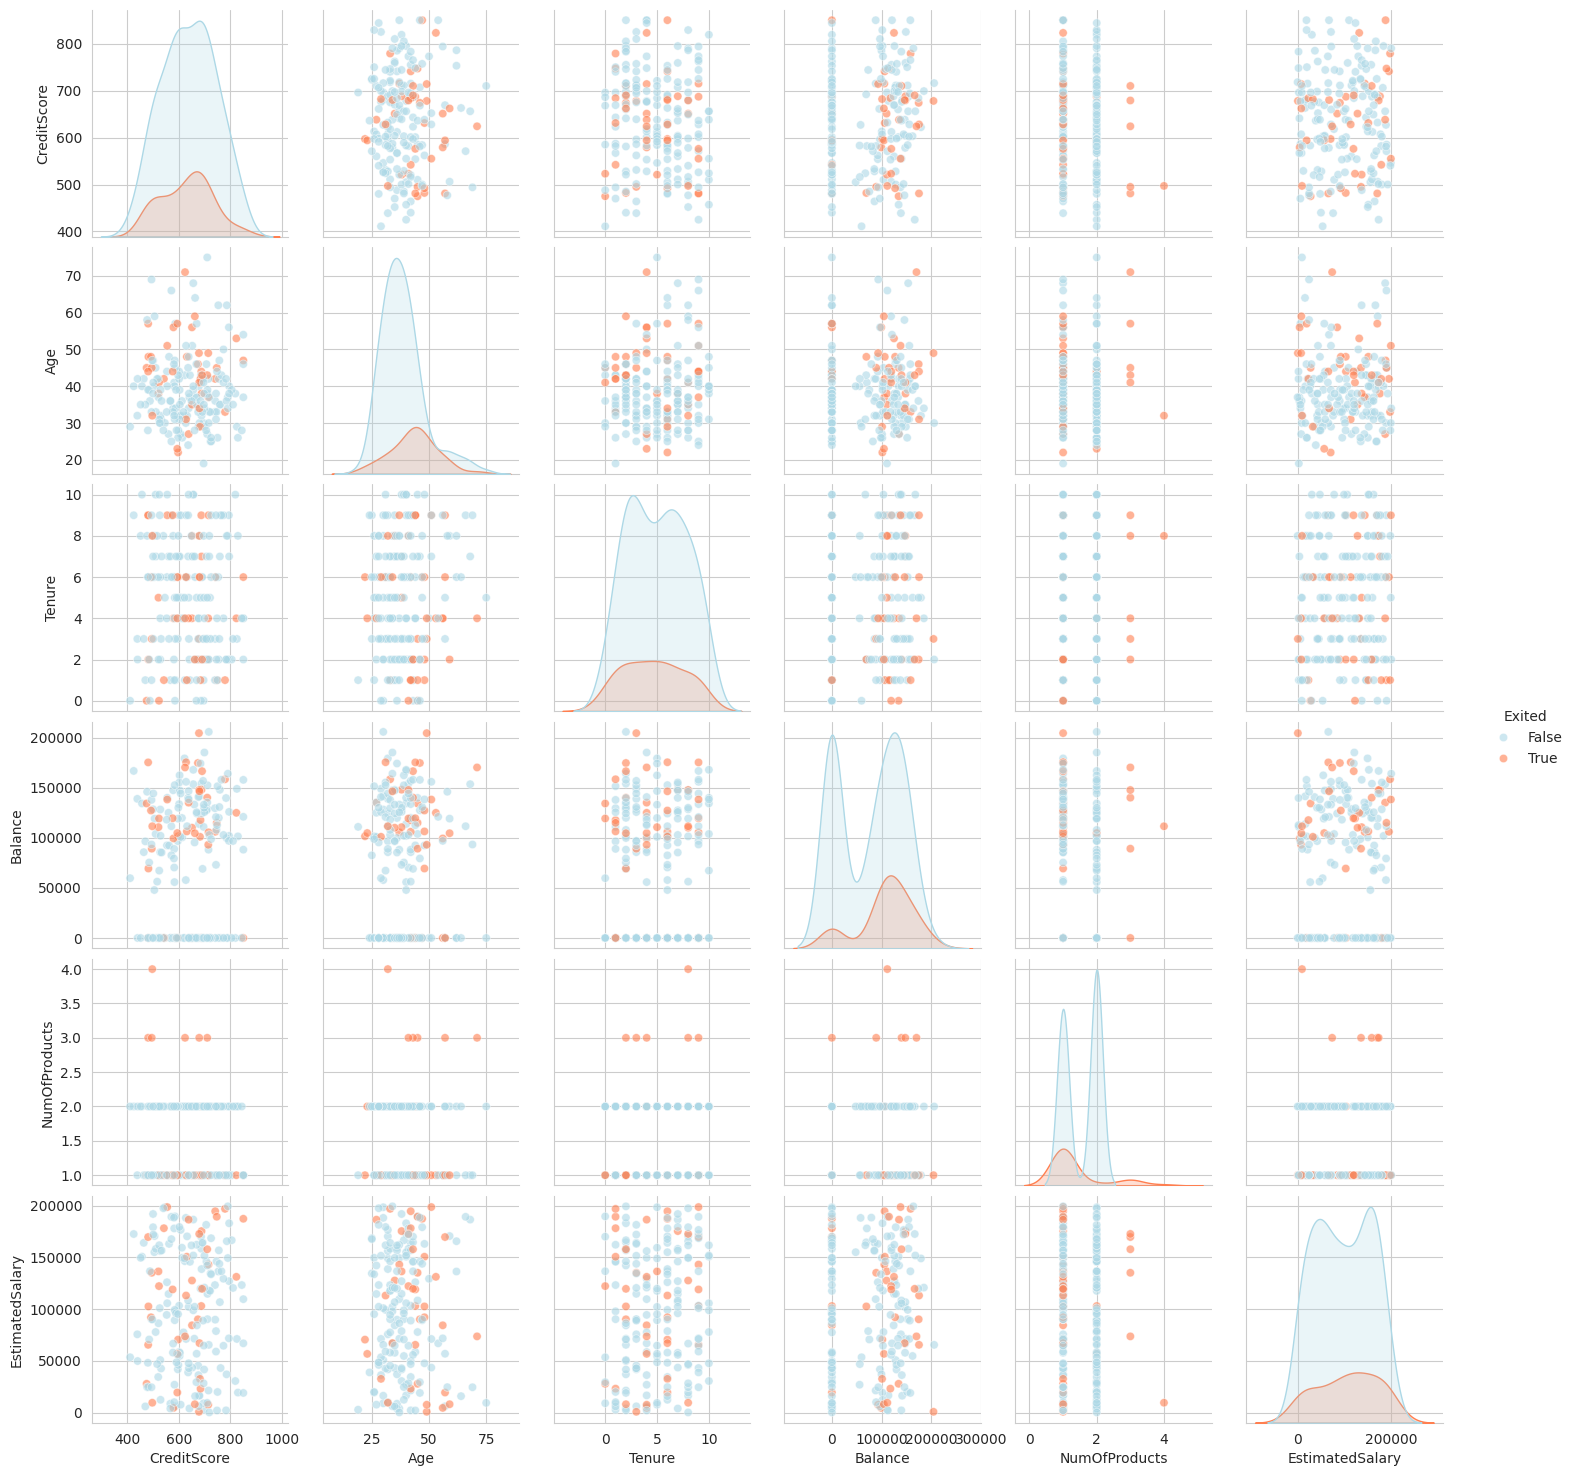

In [ ]:
# Sample the data
df_sample = df.sample(n=200, random_state=42)

# Define a custom palette: 0 (Exited=False) -> green, 1 (Exited=True) -> red
custom_palette = {0: 'lightblue', 1: 'coral'}

# Create the pairplot
sns.pairplot(df_sample, vars=num_cols, hue='Exited', palette=custom_palette, diag_kind='kde',
             plot_kws={'alpha': 0.6})  # Adjust alpha for transparency
plt.show()


**Comments:** Seems to be low correlations accross variables.
- Number of products could be an important variable to classify churned customers
- customers who churned tend to be older than the others that stayed.
- Customers whi churned have an important concentration in 1 products. If customers have 2 products or more they are less likely to churn

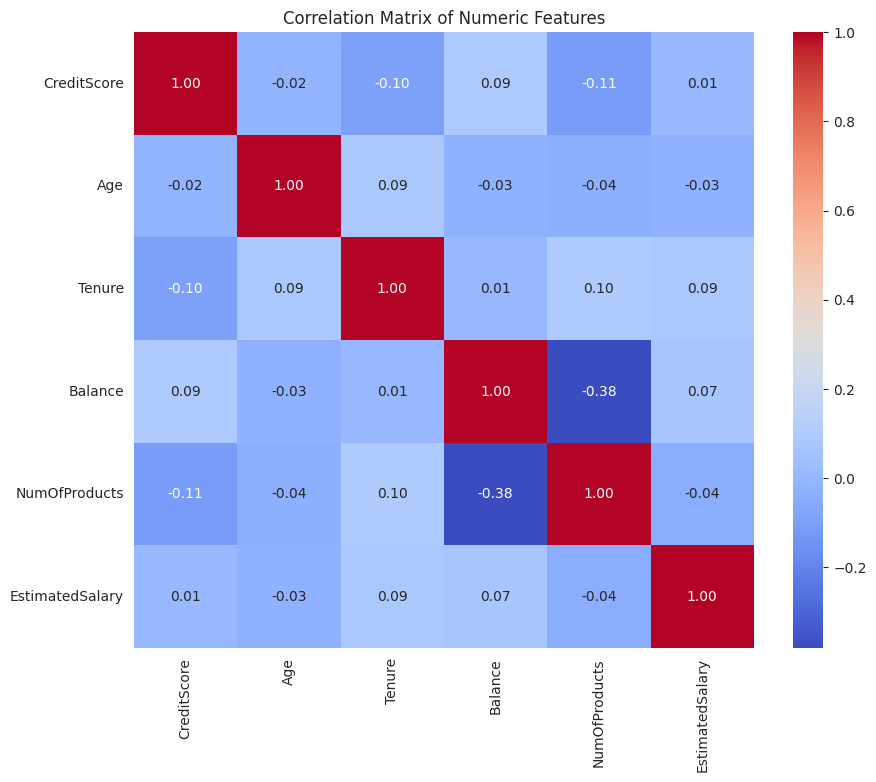

In [ ]:
# Assuming df_sample is already defined as in the provided code.
#numeric_cols = df_sample.select_dtypes(include=np.number).columns

# Calculate the correlation matrix for numeric columns
correlation_matrix = df_sample[num_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Comments:** Low correlations were identified between numeric variables. The highest correlation found is Number of products vs Balance (-0.38), followed by Number of products vs Credit Score (-0.11)

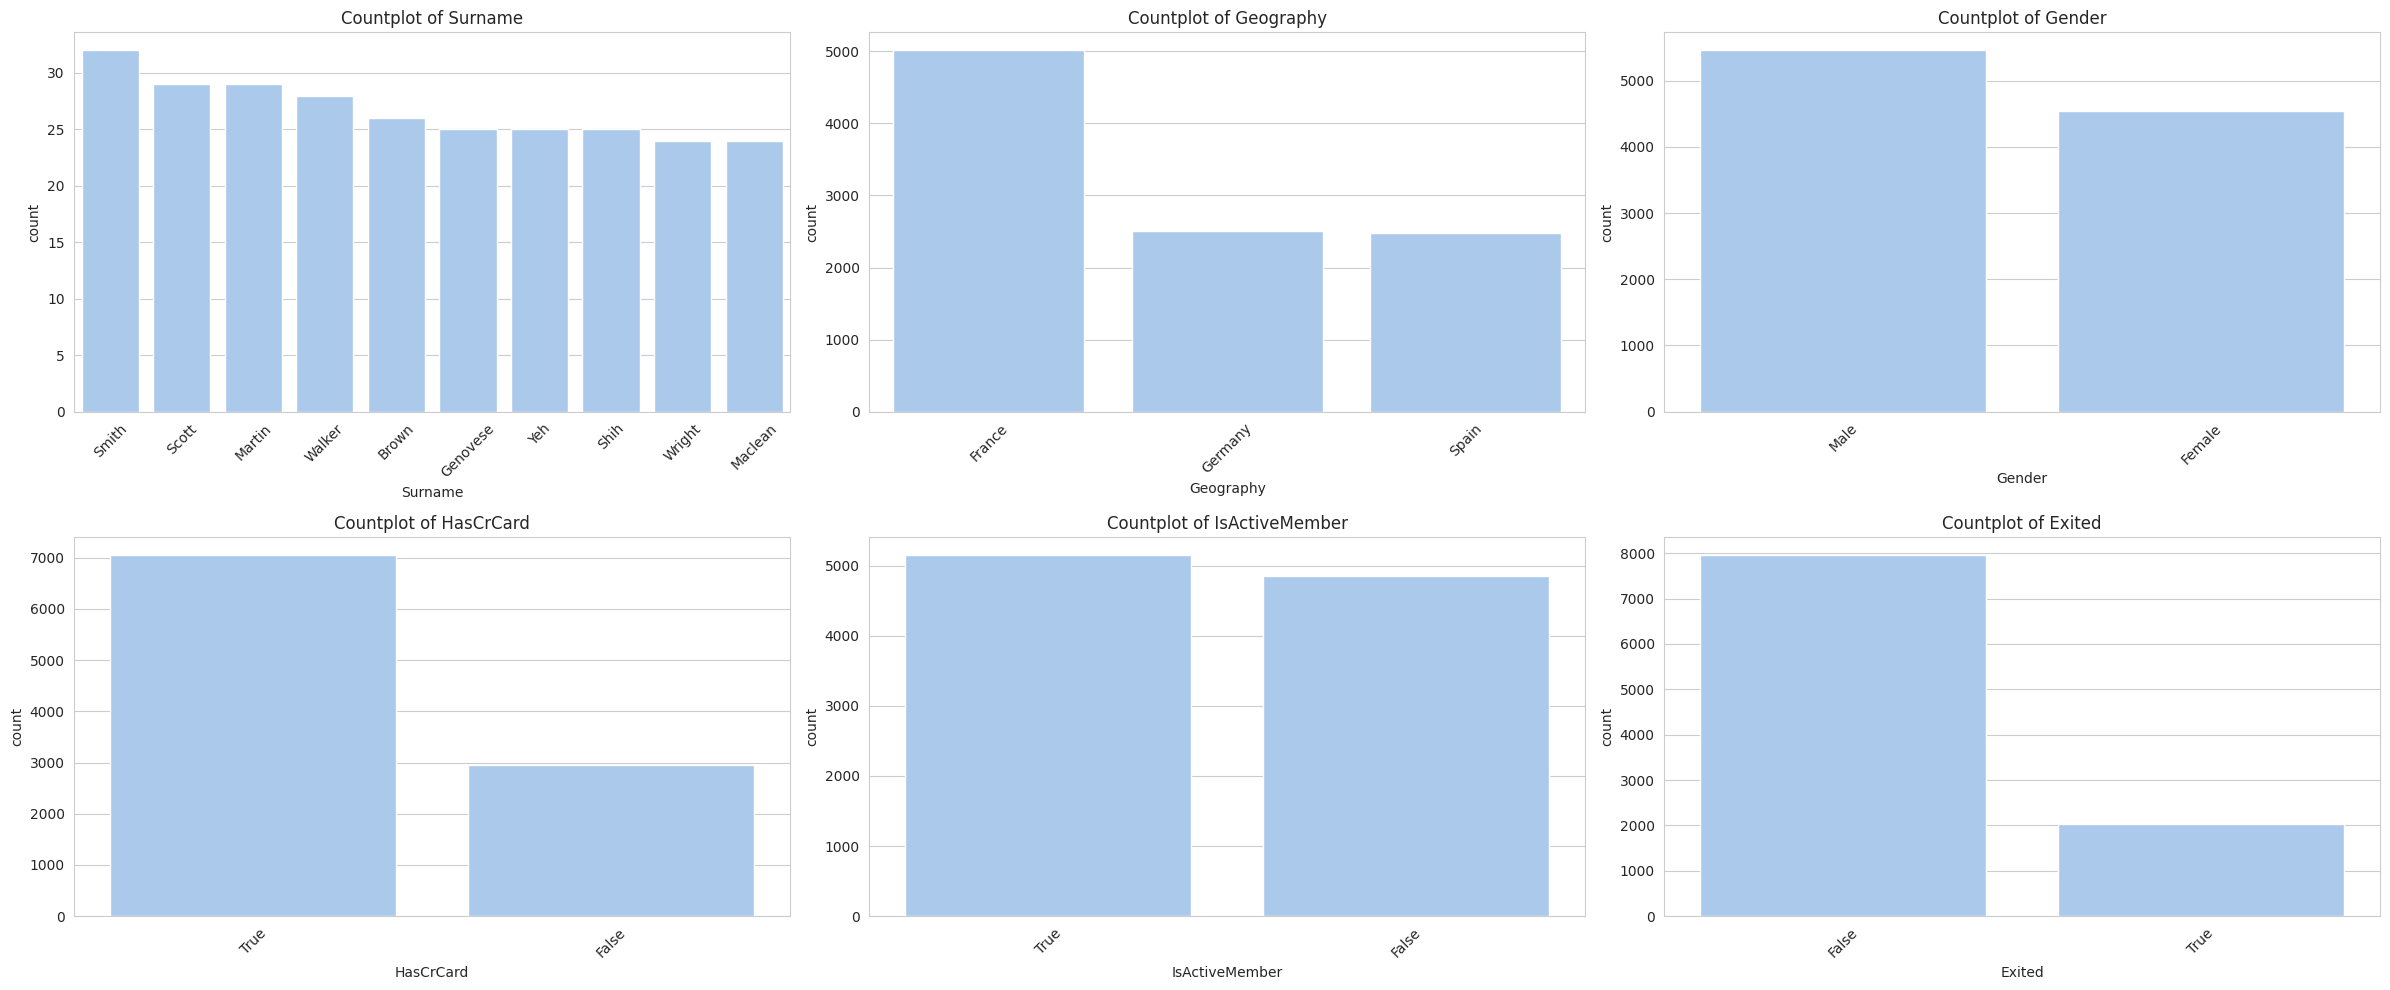

In [ ]:
# Select categorical columns
cat_cols = df.select_dtypes(include=['object','boolean']).columns.tolist()

# Define grid layout: 4 columns per row
cols = 3
rows = math.ceil(len(cat_cols) / cols)

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(24, 5 * rows))
axes = axes.flatten()

# Generate a countplot for each categorical feature
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index[:10])
    axes[i].set_title(f'Countplot of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Comments:**
- France is the country with more customers
- The majority of customers do not have a Credit Card

Exited
False    0.7963
True     0.2037
Name: proportion, dtype: float64


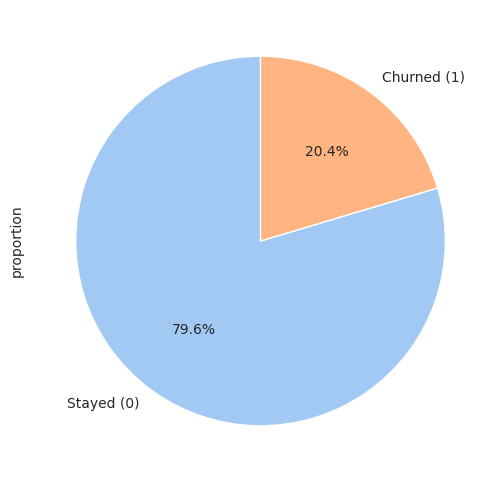

In [ ]:
df.value_counts('Exited', normalize=True).plot(kind='pie',
    autopct='%1.1f%%',
    labels=['Stayed (0)', 'Churned (1)'],
    startangle=90,
    figsize=(6, 6),
    legend=False)

print(df.value_counts('Exited', normalize=True))

**Comments:** This dataset has a 20% of churned customers (this is the target variable) so it could be said that the dataset is **umbalanced**

In [ ]:
# Detect missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
miss = missing_values.to_frame() #= missing_values[missing_values > 0]
miss = miss.rename(columns={0: 'counts'})
miss['porc_missing'] = (miss['counts']/df.shape[0])*100
miss

,counts,porc_missing
RowNumber,0,0.0
CustomerId,0,0.0
Surname,0,0.0
CreditScore,0,0.0
Geography,0,0.0
Gender,0,0.0
Age,0,0.0
Tenure,0,0.0
Balance,0,0.0
NumOfProducts,0,0.0


**Comments:** There is no missing values in the dataset

In [ ]:
# Define the credit score ranges and labels
bins = [0, 580, 670, 740, 800, 999]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

# Create the new column 'Grp_CreditScore' based on the credit score ranges
df['Grp_CreditScore'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)



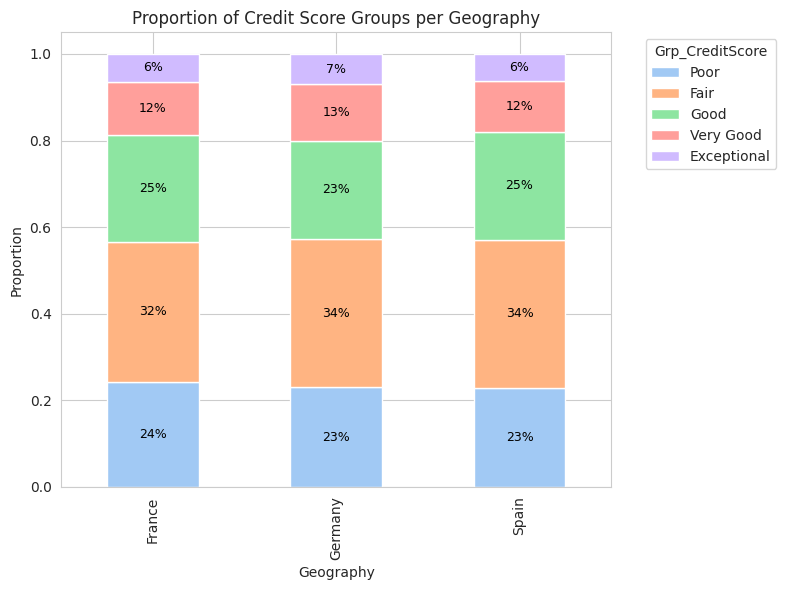

In [ ]:

# Calcular proporciones
proportions = (
    df.groupby('Geography')['Grp_CreditScore']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Crear gráfico
ax = proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6)
)

# Añadir etiquetas sobre cada segmento en color negro
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0.01:  # Mostrar solo si es mayor al 1%
            ax.annotate(
                f'{height:.0%}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                ha='center', va='center',
                fontsize=9, color='black'  # <- Etiquetas en negro
            )

plt.title('Proportion of Credit Score Groups per Geography')
plt.xlabel('Geography')
plt.ylabel('Proportion')
plt.legend(title='Grp_CreditScore', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




**Comments:** Proportions of the Credit Score groups are very similar across countries. The Credit policy of the bank must be the same in all countries

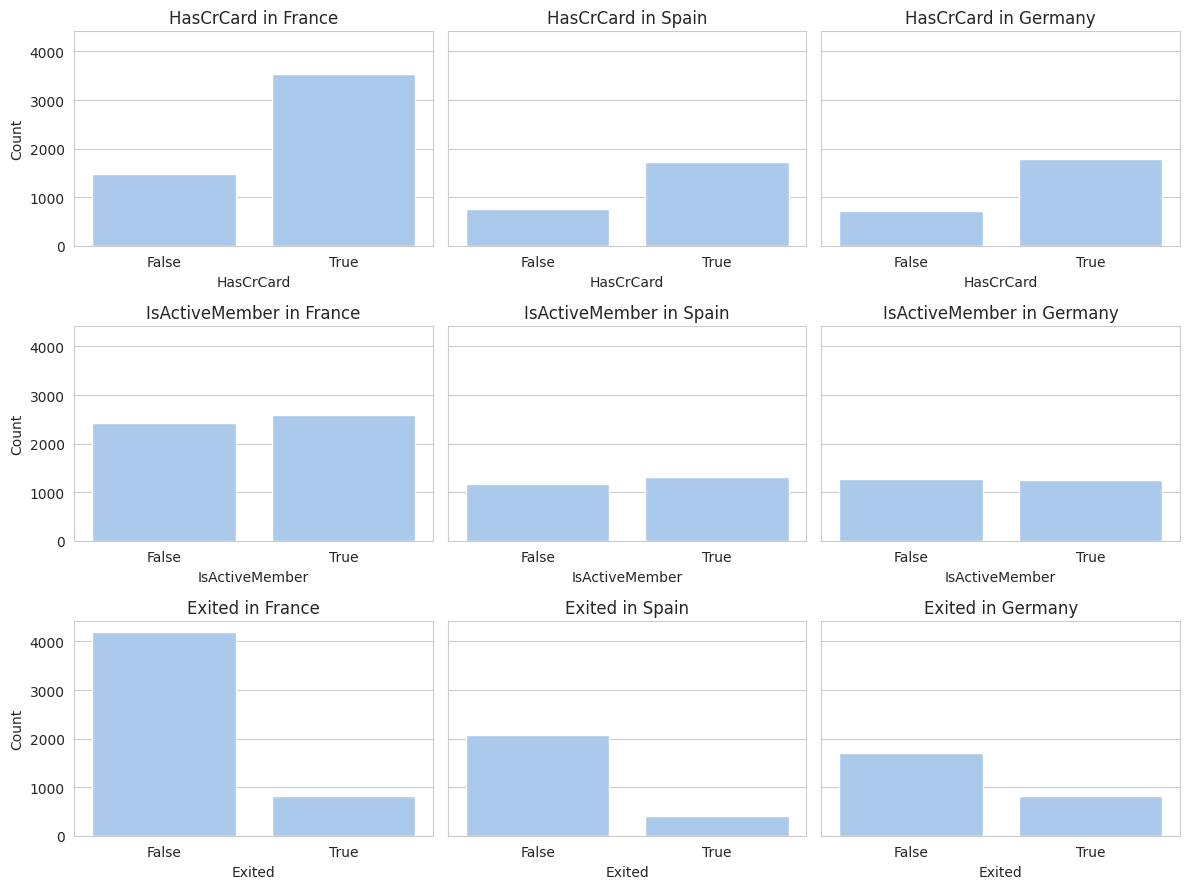

In [ ]:
# Define boolean columns
bool_cols = ['HasCrCard', 'IsActiveMember', 'Exited']

# Unique geographies and boolean columns
geos = df['Geography'].unique()
rows = len(bool_cols)
cols = len(geos)

# Create subplots with one row per boolean variable, and one column per geography
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharey=True)

# Ensure axes is 2D
if rows == 1:
    axes = np.expand_dims(axes, axis=0)
if cols == 1:
    axes = np.expand_dims(axes, axis=1)

# Iterate through boolean variables and geographies
for i, col in enumerate(bool_cols):
    for j, geo in enumerate(geos):
        ax = axes[i][j]
        sns.countplot(x=col, data=df[df['Geography'] == geo], ax=ax)
        ax.set_title(f'{col} in {geo}')
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
df.groupby('Geography')['Exited'].agg(['count', 'sum','mean']).sort_values(by='mean', ascending=False)

,count,sum,mean
Geography,,,
Germany,2509,814,0.324432
Spain,2477,413,0.166734
France,5014,810,0.161548


**Comments:** There is more attrition as a ratio (2x) in Germany than the others countries

In [ ]:
df.groupby('Geography')['HasCrCard'].agg(['count', 'sum','mean']).sort_values(by='mean', ascending=False)

,count,sum,mean
Geography,,,
Germany,2509,1791,0.713830
France,5014,3543,0.706621
Spain,2477,1721,0.694792


**Comments:** As a ratio, there is a similar level of cardholders accross countries

In [ ]:
df.groupby('Geography')['IsActiveMember'].agg(['count', 'sum','mean']).sort_values(by='mean', ascending=False)

,count,sum,mean
Geography,,,
Spain,2477,1312,0.529673
France,5014,2591,0.516753
Germany,2509,1248,0.497409


**Comments:** The % of active members is similar in all countries. However **Germany has the lower activation ratio**

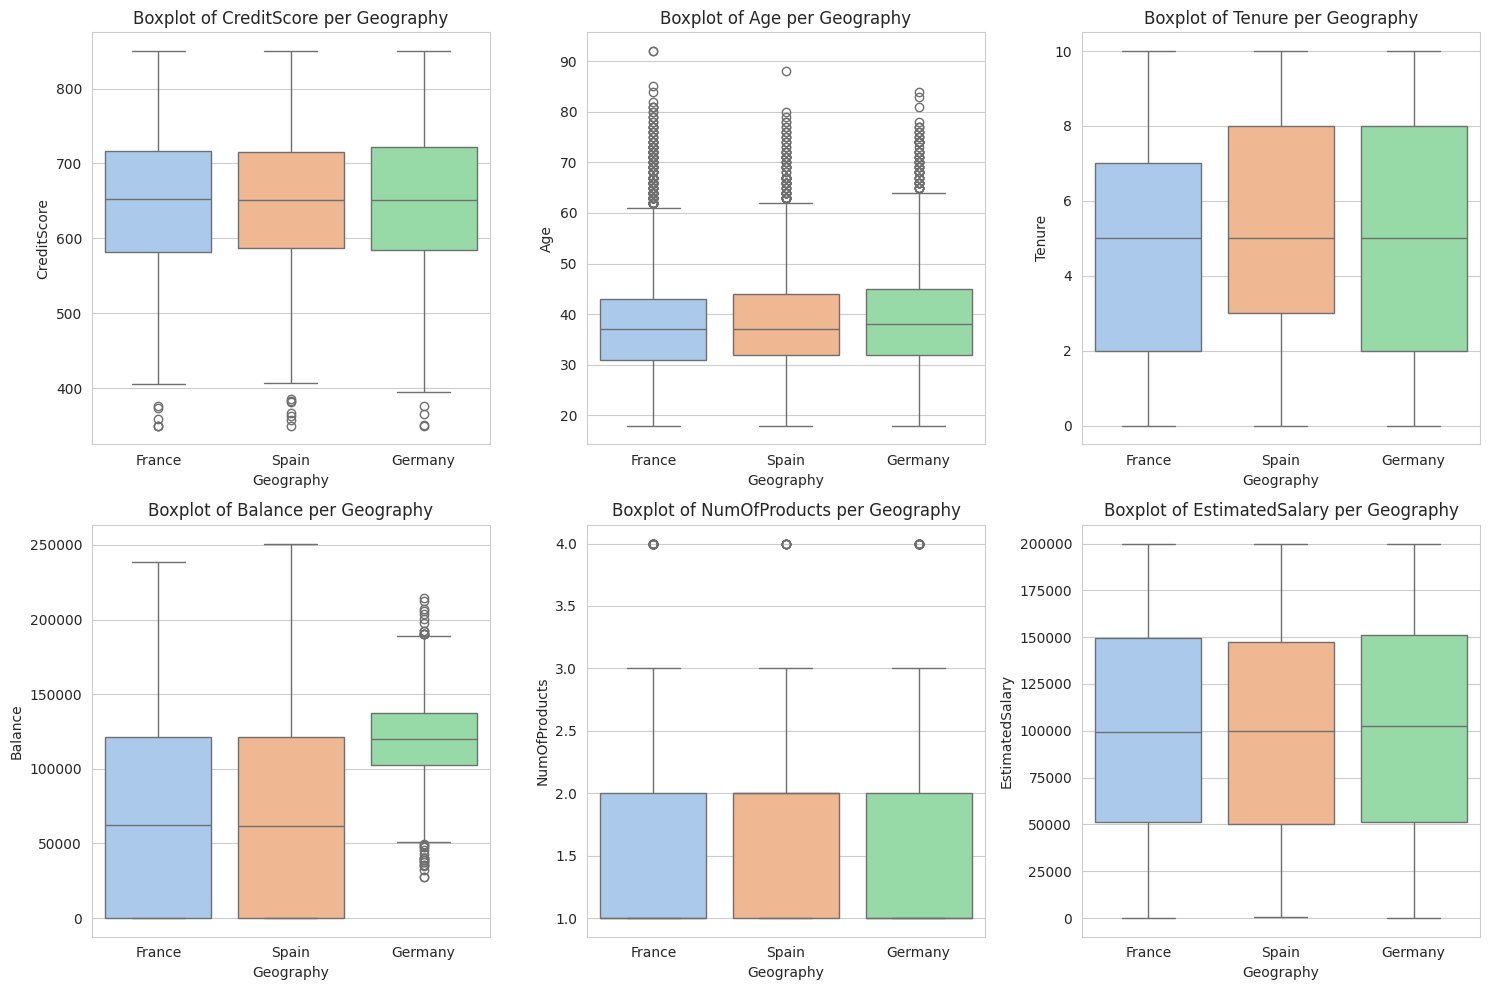

In [ ]:
# Define the number of rows and columns for the subplots
n_rows = 2
n_cols = 3

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through numeric columns and create boxplots
for i, col in enumerate(num_cols):
    if i < len(axes):  # Check if we're still within the axes limits
        sns.boxplot(y=col, x='Geography', data=df, ax=axes[i], hue='Geography')
        axes[i].set_title(f'Boxplot of {col} per Geography')
    else:
        break  # Stop if we run out of axes

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()


**Comments:** Numeric variables behave similarly among geographies. Only **Germany reports a different Balance distribution**